# Pre-lab setup

In [3]:
import pandas as pd
import numpy as np

import re

from sklearn import decomposition
# from sklearn.decomposition import TruncatedSVD

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
! pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 4.7 MB/s  0:00:05m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [gensim]2m2/3 [gensim]


In [5]:
! pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 13.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pyLDAvis]2/3 [pyLDAvis]


In [ ]:
# gensim for LDA
import gensim
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import LsiModel
from gensim.models import TfidfModel
from gensim.corpora import MmCorpus
from gensim.models import CoherenceModel

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim

In [7]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
## set read/write paths for easy access
file_path = '/content/drive/MyDrive/Year One/Fall/NLP/Lab5'

## LSA Helpers

In [8]:
def batch_lsa(id2word, corpus, texts, stop, start, step, coherence_measure='c_v'):
  # initialize lists
  coherence_scores = []
  model_list = []

  for n_topics in range(start, stop+1, step):
    # train model
    lsa_model = LsiModel(
        corpus,
        id2word=id2word,
        num_topics=n_topics
    )

    # Store model
    model_list.append(lsa_model)

    # calculate coherence
    coherence_model_lsa = CoherenceModel(
        model=lsa_model,
        texts=texts,
        dictionary=id2word,
        coherence=coherence_measure
    )
    # store coherence
    coherence_scores.append(coherence_model_lsa.get_coherence())

  return model_list, coherence_scores


In [25]:
def vis_lsa(lsa_model, n_words=15):
  topic_words = pd.DataFrame({})

  for i, topic in enumerate(lsa_model.get_topics()):
    top_feature_ids = topic.argsort()[-n_words:][::-1]
    feature_values = topic[top_feature_ids]
    words = [id2word[id] for id in top_feature_ids]
    topic_df = pd.DataFrame({'value' : feature_values, 'word' : words, 'topic' : i})
    topic_words = pd.concat([topic_words, topic_df], ignore_index=True)

  g = sns.FacetGrid(topic_words, col="topic", col_wrap=3, sharey=False)
  g.map(plt.barh, "word", "value")

## LDA Helpers

In [9]:
## creates a set of LDA models and also returns coherence metric
def batch_lda(corpus, id2word, start, stop, step, chunksize=1500, passes=20, iterations=400, eval_every=None, gamma_threshold=0.001, alpha='auto', eta='auto', coherence_measure='c_v'):

  # initialize lists
  coherence_scores = []
  model_list = []

  for n_topics in range(start, stop, step):

    # train LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                chunksize=chunksize,
                                                passes = passes,
                                                alpha=alpha,
                                                eta=eta,
                                                iterations=iterations,
                                                num_topics=n_topics,
                                                per_word_topics=True,
                                                eval_every=eval_every,
                                                gamma_threshold=gamma_threshold)

    model_list.append(lda_model)

    ## calculate coherence
    coherence_model_lda = CoherenceModel(model=lda_model,
                                      texts=texts,
                                      dictionary=id2word,
                                      coherence=coherence_measure)

    coherence_scores.append(coherence_model_lda.get_coherence())

  return model_list, coherence_scores

# Part 1: Prep the Data

In [12]:
review_df = pd.read_csv(f"data/review_tokenized.csv", header=0, index_col=0)
print(review_df.head())

                      Appname  \
recommendationid                
212664845         ARC Raiders   
212664705         ARC Raiders   
212664692         ARC Raiders   
212664560         ARC Raiders   
212664471         ARC Raiders   

                                                     review_cleaned  
recommendationid                                                     
212664845                           addictive stressful time waster  
212664705         steam comment section like every comment secti...  
212664692         like gathering sneak around arc pvp part peopl...  
212664560         well make game every time hop experience somet...  
212664471         think would sweaty honestly somehow stop playi...  


In [ ]:
review_df.shape

(63208, 9)

## Check for Digits or Punctuation

In [14]:
## use regex to check for special characters
review_df['contains_special_characters'] = review_df['review_cleaned'].apply(lambda x:re.search(r"[^\w\s]+", x))
review_df['contains_special_characters'].head()

recommendationid
212664845    None
212664705    None
212664692    None
212664560    None
212664471    None
Name: contains_special_characters, dtype: object

In [15]:
## will return true if any of these cleaned reviews contain non-word, non-space characters
review_df['contains_special_characters'].any()

np.True_

# Part 2: Create the Dictionary

In [16]:
from gensim.models.phrases import Phrases, Phraser

In [18]:
# create a stream of sequence
sent = [text.split() for text in review_df['review_cleaned']]
bigram = Phrases(sent, min_count=40)

bigram_phraser = Phraser(bigram)

In [19]:
# apply the exported model to each review of the corpus
texts = bigram_phraser[sent]

In [20]:
# build the id2word dictionary
id2word = Dictionary(texts)

# filter very frequently and rare tokens
id2word.filter_extremes(no_below=60, no_above=0.50)


In [21]:
print("Size of dictionary: ", len(id2word))

Size of dictionary:  2422


# Part 3: LSA using BOW

In [22]:
## create corpus
bow_corpus = [id2word.doc2bow(text) for text in texts]

In [23]:
## run the bag of words model
bow_models, bow_coherence = batch_lsa(id2word, bow_corpus, texts, 10, 2, 2, coherence_measure='c_v')

bow_coherence

[np.float64(0.475434657522862),
 np.float64(0.4456231265860843),
 np.float64(0.457514775272376),
 np.float64(0.4332384333951945),
 np.float64(0.4387195050846323)]

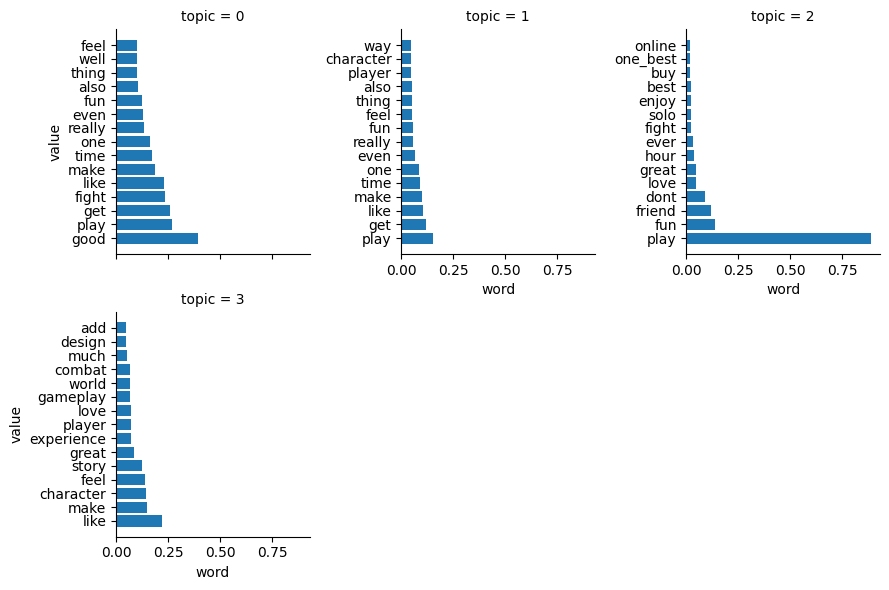

In [26]:
vis_lsa(bow_models[1])

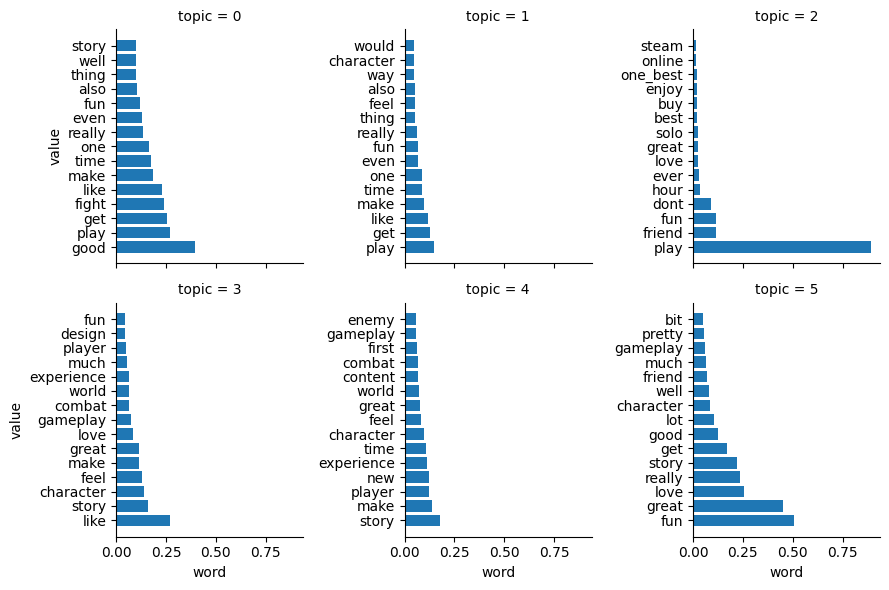

In [27]:
vis_lsa(bow_models[2])

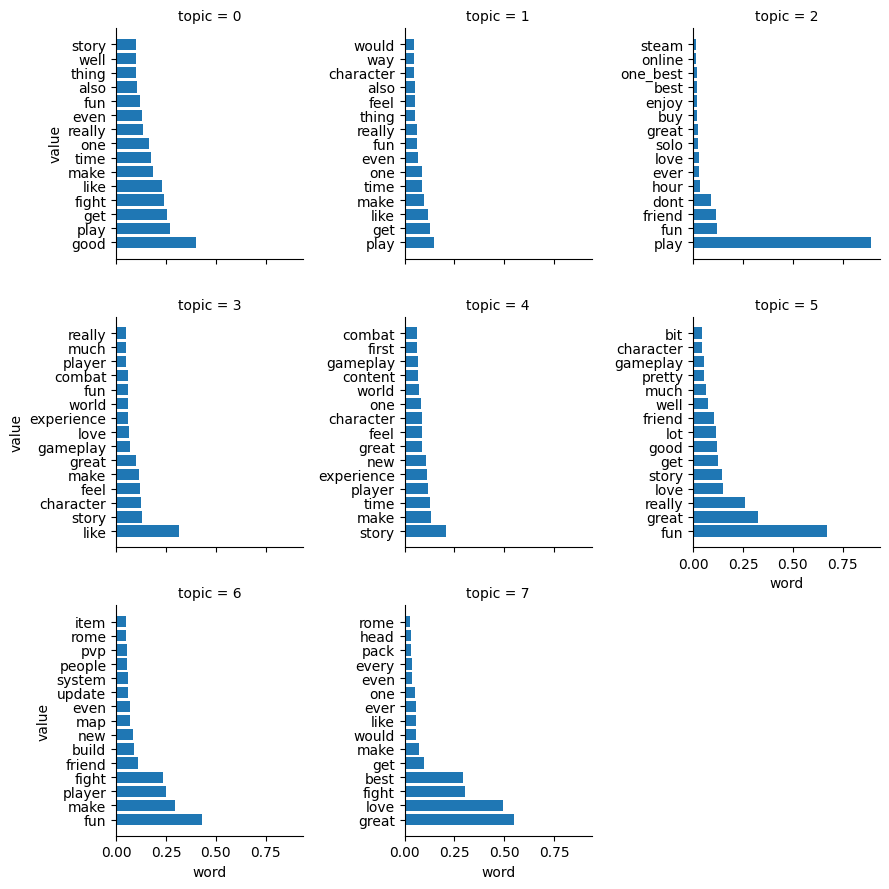

In [28]:
vis_lsa(bow_models[3])

# Part 4: LSA using TFIDF

In [29]:
tfidf_corpus = TfidfModel(bow_corpus)[bow_corpus]

In [30]:
## run the tfidf LSA models
tfidf_models, tfidf_coherence = batch_lsa(id2word, tfidf_corpus, texts, 10, 2, 2, coherence_measure='c_v')

tfidf_coherence

[np.float64(0.39116668832611917),
 np.float64(0.4059364367676344),
 np.float64(0.41704940662584894),
 np.float64(0.4077561451962393),
 np.float64(0.4129771049560282)]

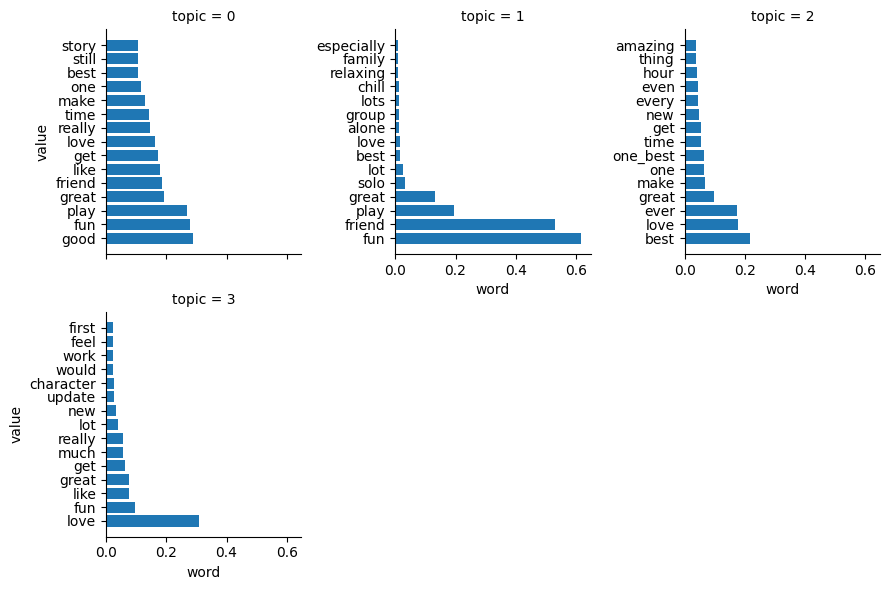

In [31]:
vis_lsa(tfidf_models[1])

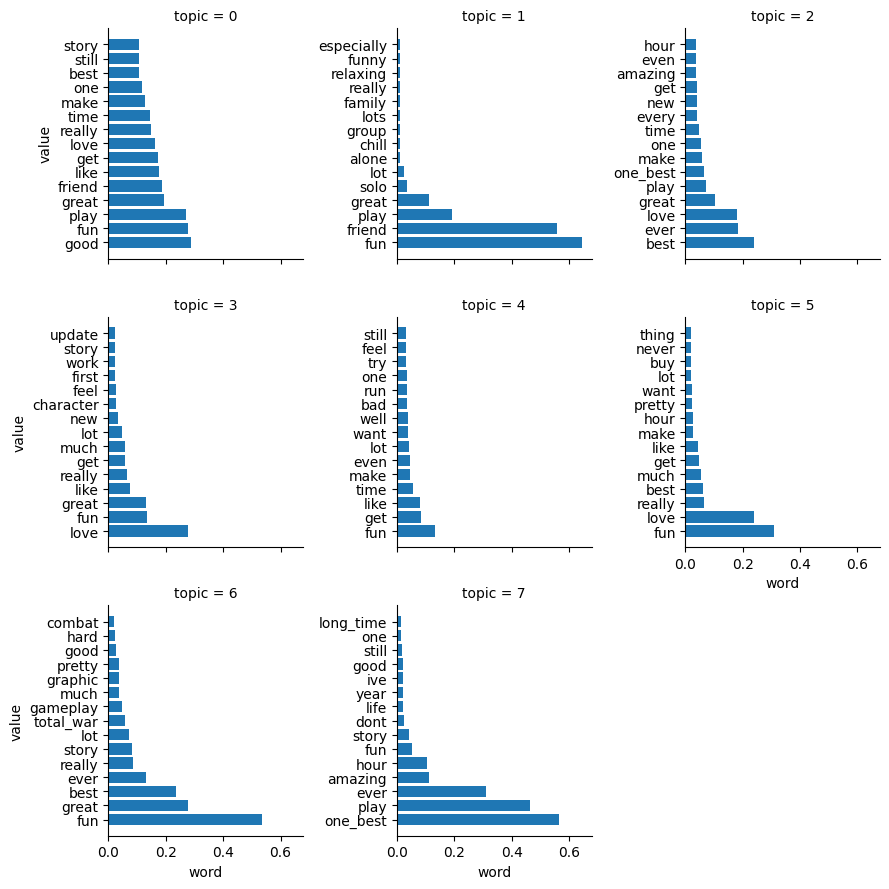

In [32]:
vis_lsa(tfidf_models[3])

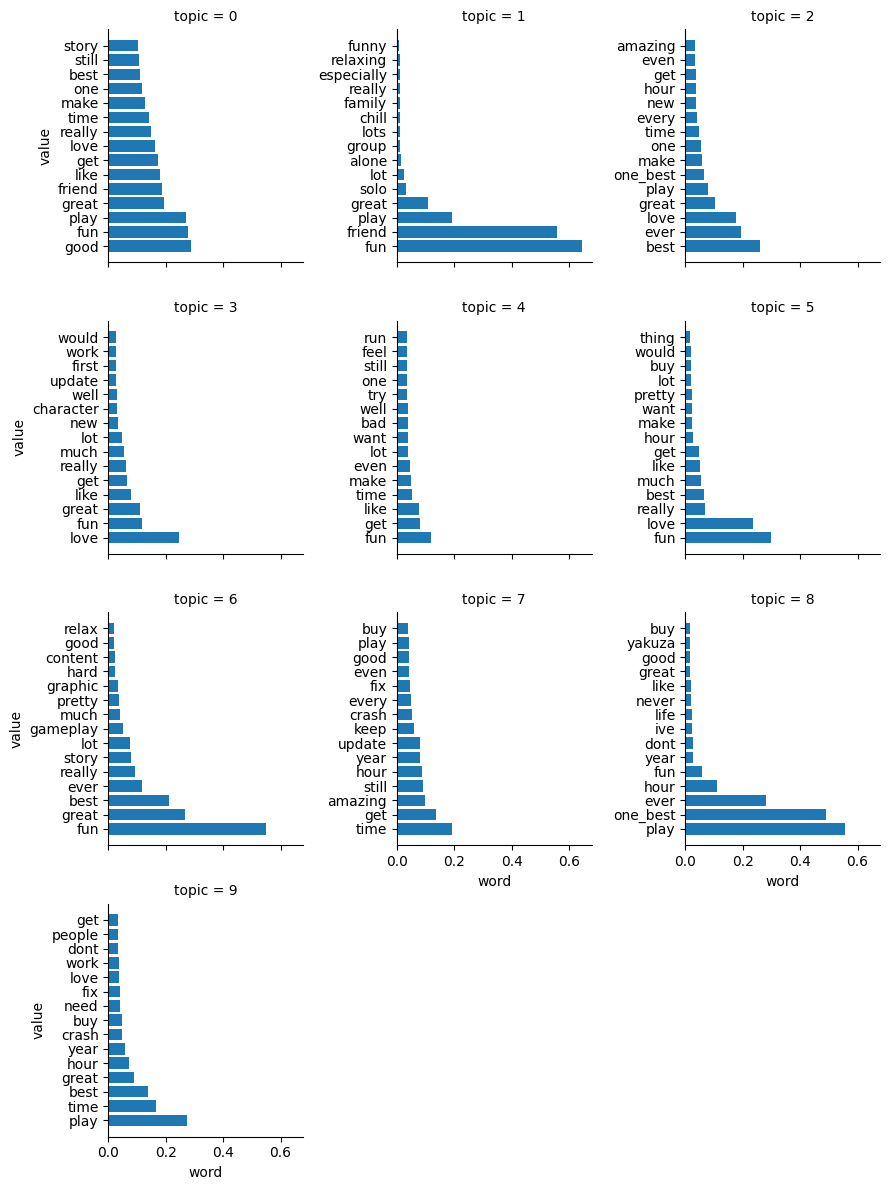

In [33]:
vis_lsa(tfidf_models[4])

# Part 5: LDA

In [34]:
## run the lda models
lda_models, lda_coherence = batch_lda(bow_corpus, id2word, 4, 18, 2, coherence_measure='c_v')

lda_coherence

[np.float64(0.4542991804681784),
 np.float64(0.46770627189702135),
 np.float64(0.41630772731417204),
 np.float64(0.39567631899808414),
 np.float64(0.4370763065183823),
 np.float64(0.4248814621491969),
 np.float64(0.4016378475770974)]

## Coherence Plot

range(4, 18, 2)
[np.float64(0.4542991804681784), np.float64(0.46770627189702135), np.float64(0.41630772731417204), np.float64(0.39567631899808414), np.float64(0.4370763065183823), np.float64(0.4248814621491969), np.float64(0.4016378475770974)]


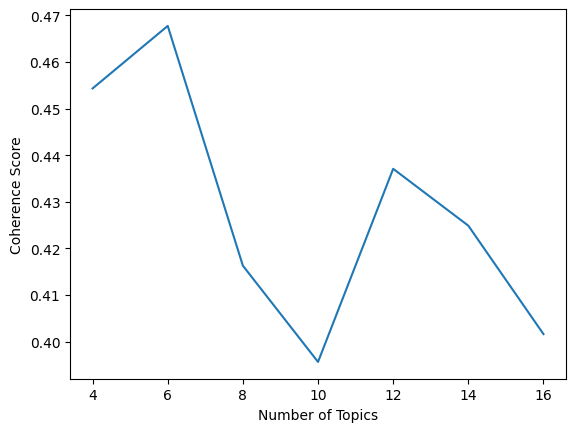

In [35]:
## visualize coherence scores together
x = range(4, 18, 2)
y = lda_coherence

print(x)
print(y)

plt.plot(x, y)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

## 8 topics

In [36]:
## create and visualize LDA
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_models[2], bow_corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.219354 -0.014106       1        1  30.895330
6      0.177538  0.074029       2        1  23.213573
7      0.159463  0.035436       3        1  15.471284
2      0.035153 -0.118581       4        1   7.878648
5      0.028894 -0.215119       5        1   7.226918
0     -0.127347  0.045900       6        1   6.866053
4     -0.158822  0.369704       7        1   6.257203
3     -0.334232 -0.177264       8        1   2.190991, topic_info=               Term          Freq         Total Category  logprob  loglift
82             play  18949.000000  18949.000000  Default  30.0000  30.0000
36              fun  11735.000000  11735.000000  Default  29.0000  29.0000
137            good  13440.000000  13440.000000  Default  28.0000  28.0000
178           great   8546.000000   8546.000000  Default  27.0000  27.0000
56             like  13307.000000  13307.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
1414           town    214.905034    215.754690   Topic8  -4.6347   3.8169
2376       terraria    212.370155    213.220890   Topic8  -4.6466   3.8168
1381  warhammer_40k    212.424208    213.278946   Topic8  -4.6464   3.8168
1376         scream    202.609736    203.459244   Topic8  -4.6937   3.8166
1181          heart    411.171234    421.001067   Topic8  -3.9859   3.7972

[387 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
900       2  0.999277          ability
1567      7  0.997378  absolutely_love
477       4  0.998480              act
240       1  0.415275              add
240       2  0.584268              add
...     ...       ...              ...
2385      6  0.998451           yakuza
915       8  0.998671             yeah
159       1  0.999535             year
358       3  0.999074              yes
1502      1  0.999427           zombie

[521 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 8, 3, 6, 1, 5, 4])

## 10 topics

In [37]:
## create and visualize LDA
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_models[3], bow_corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.242396 -0.106141       1        1  22.940710
0     -0.229359 -0.049532       2        1  20.839352
6     -0.098377  0.088311       3        1  13.981375
7     -0.091254 -0.226286       4        1  12.126436
2     -0.083332  0.062192       5        1   9.724172
4      0.004108  0.188690       6        1   9.710651
9      0.061800  0.326820       7        1   5.539656
5      0.234334 -0.107262       8        1   1.963979
1      0.234091 -0.105907       9        1   1.918742
8      0.210385 -0.070885      10        1   1.254927, topic_info=               Term          Freq         Total Category  logprob  loglift
82             play  18106.000000  18106.000000  Default  30.0000  30.0000
137            good  14226.000000  14226.000000  Default  29.0000  29.0000
36              fun  11624.000000  11624.000000  Default  28.0000  28.0000
39              get  13964.000000  13964.000000  Default  27.0000  27.0000
178           great   8465.000000   8465.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
1036          janky    152.711901    153.599249  Topic10  -4.4191   4.3723
1488            joy    150.716567    151.603900  Topic10  -4.4323   4.3722
1950  art_direction    150.509907    151.397376  Topic10  -4.4336   4.3722
1951    atmospheric    148.728293    149.615783  Topic10  -4.4455   4.3721
2263        ubisoft    142.140069    143.027365  Topic10  -4.4908   4.3719

[460 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1543     10  0.998369      40k
900       3  0.992938  ability
900       5  0.005510  ability
464       1  0.004098     able
464       2  0.068028     able
...     ...       ...      ...
159       6  0.999752     year
358       1  0.005409      yes
358       6  0.993024      yes
207       1  0.999351      yet
1502      8  0.999227   zombie

[627 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 7, 8, 3, 5, 10, 6, 2, 9])

## 12 topics

In [38]:
## create and visualize LDA
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_models[4], bow_corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.213539 -0.069106       1        1  19.479067
1      0.199769  0.011230       2        1  15.906684
0      0.216654 -0.121846       3        1  14.623844
5      0.198674 -0.085854       4        1  14.058507
11     0.049870  0.258518       5        1  12.278245
2     -0.002632  0.302443       6        1   5.437941
10    -0.126511  0.032479       7        1   4.041573
4     -0.156579  0.111864       8        1   3.629010
3     -0.143326 -0.153187       9        1   3.171926
9     -0.126378 -0.085382      10        1   2.890408
8     -0.146043 -0.092326      11        1   2.629713
6     -0.177035 -0.108834      12        1   1.853083, topic_info=           Term          Freq         Total Category  logprob  loglift
82         play  18798.000000  18798.000000  Default  30.0000  30.0000
137        good  13360.000000  13360.000000  Default  29.0000  29.0000
56         like  12985.000000  12985.000000  Default  28.0000  28.0000
36          fun  12072.000000  12072.000000  Default  27.0000  27.0000
178       great   8791.000000   8791.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
2279    kingdom    173.687279    174.599982  Topic12  -4.6802   3.9831
1079       buck    171.908993    172.821661  Topic12  -4.6905   3.9830
1923       flow    164.575110    165.487795  Topic12  -4.7341   3.9828
2066       rule    159.326646    160.239325  Topic12  -4.7665   3.9826
1958  variation    152.662859    153.575562  Topic12  -4.8092   3.9824

[527 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
900       6  0.999089      ability
464       2  0.998784         able
1596      6  0.997404  achievement
477      12  0.998237          act
845       5  0.997835       action
...     ...       ...          ...
358       2  0.003454          yes
358       3  0.995772          yes
1981     11  0.997318         zero
1502     11  0.999068       zombie
1473     10  0.995880         zone

[705 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 2, 1, 6, 12, 3, 11, 5, 4, 10, 9, 7])